<a href="https://colab.research.google.com/github/edreyesc/ProyectoFinal/blob/main/proyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Final - Modelos Predictivos**

## 1. Carga de librerias

In [206]:
#Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


## 2. Carga de datos y exploración

In [207]:
#Adquisición de datos
df_gold = pd.read_csv('https://raw.githubusercontent.com/edreyesc/ProyectoFinal/main/Gold%20Historical%20Data.csv')

In [208]:
# Número de observaciones y variables
df_gold.shape

(2816, 7)

In [209]:
# Inspección de datos del dataframe, primeras 5 filas
df_gold.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/31/2024,"2,641.00","2,620.00","2,642.00","2,614.30",86.29K,0.87%
1,12/30/2024,"2,618.10","2,636.10","2,640.70","2,608.40",110.92K,-0.01%
2,12/27/2024,"2,618.40","2,639.70","2,639.70","2,612.10",0.64K,-0.83%
3,12/26/2024,"2,640.30","2,623.30","2,642.40","2,622.80",1.40K,0.67%
4,12/24/2024,"2,622.80","2,616.50","2,622.70","2,612.50",0.42K,0.28%


In [210]:
# Inspección de datos del dataframe, últimas 5 filas
df_gold.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2811,01/08/2014,"1,225.50","1,231.00","1,231.80","1,217.70",157.11K,-0.33%
2812,01/07/2014,"1,229.60","1,237.00","1,244.70","1,224.20",128.64K,-0.68%
2813,01/06/2014,"1,238.00","1,237.00","1,247.70","1,212.60",152.19K,-0.05%
2814,01/03/2014,"1,238.60","1,222.30","1,239.60","1,221.30",114.98K,1.09%
2815,01/02/2014,"1,225.20","1,204.50","1,230.80","1,202.50",136.92K,1.90%


In [211]:
# Descrpción de los tipos de variables que contiene el dataset
df_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2816 entries, 0 to 2815
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2816 non-null   object
 1   Price     2816 non-null   object
 2   Open      2816 non-null   object
 3   High      2816 non-null   object
 4   Low       2816 non-null   object
 5   Vol.      2814 non-null   object
 6   Change %  2816 non-null   object
dtypes: object(7)
memory usage: 154.1+ KB


In [212]:
# Valores nulos por columna
df_gold.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,2
Change %,0


In [213]:
# Estadísticas básicas
df_gold.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,2816,2816,2816,2816,2816,2814,2816
unique,2816,2342,2289,2310,2328,2030,466
top,01/27/2014,"1,274.20","1,280.70","1,283.90","1,320.80",0.57K,0.00%
freq,1,5,6,6,6,17,33


## 3. Preparar el dataframe para optimizarlo en el uso de los métodos

In [214]:
# Selección de las columnas que se van a utilizar
df_gold = df_gold[['Date', 'Price']].copy()
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold.set_index('Date', inplace=True)

In [215]:
#Transformación de columna numérica a float y eliminar la coma que venía del csv
df_gold['Price'] = df_gold['Price'].replace({',':''}, regex=True).astype(float)

In [216]:
# Ordenar el dataframe ya que según lo que se observó en la inspección inicial, se inicia desde el 2024 al 2014
df_gold.sort_index(inplace=True)
df_gold = df_gold.asfreq('B')  # Asignar frecuencia de días hábiles

# Opción 1: interpolar valores faltantes suavemente
df_gold['Price'] = df_gold['Price'].interpolate(method='linear')

In [217]:
# Se verifica que la columna Date esté funcionando como index al no aparecer en la descripción de las variables y se verifica que la variable Price esté como tipo float
df_gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2869 entries, 2014-01-02 to 2024-12-31
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2869 non-null   float64
dtypes: float64(1)
memory usage: 44.8 KB


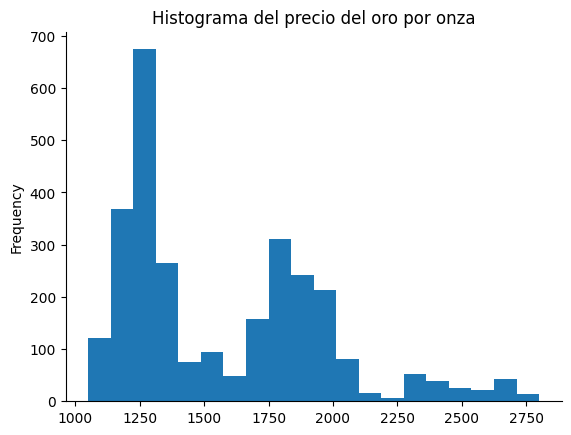

In [218]:
# Histograma para ver dónde se aglomeran los precios del oro en este lapso de 11 años
df_gold['Price'].plot(kind='hist', bins=20, title='Histograma del precio del oro por onza')
plt.gca().spines[['top', 'right',]].set_visible(False)

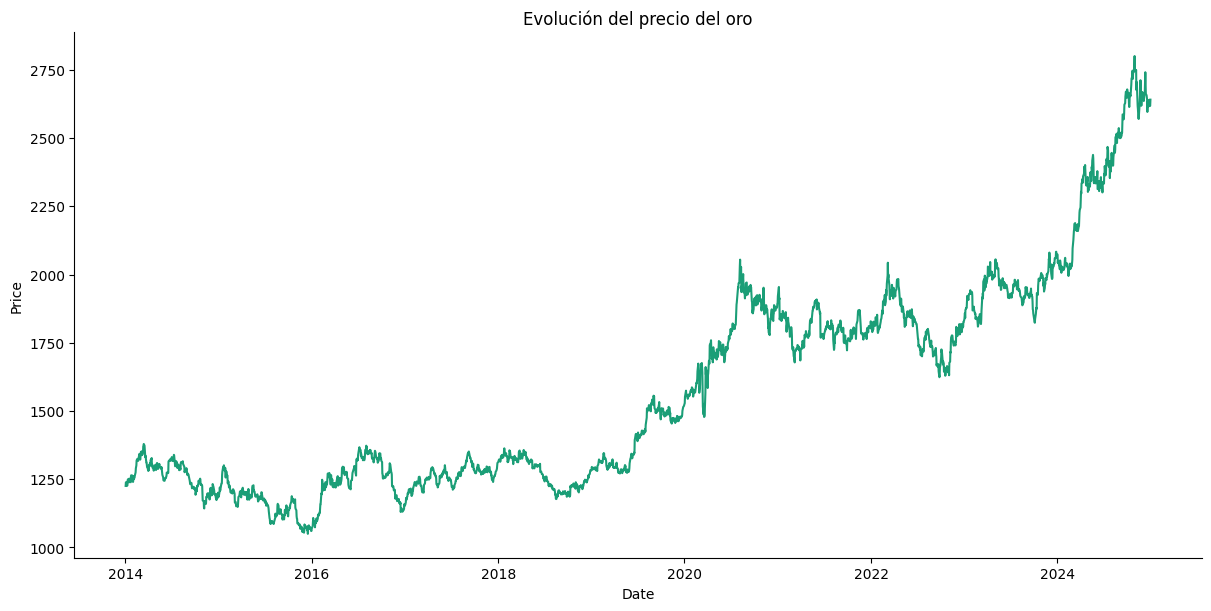

In [219]:
# Gráfica Date vs Price para revisar a manera general la tendencia de los datos

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series.index
  ys = series['Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
_plot_series(df_gold, '')
plt.title('Evolución del precio del oro')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Price')

## 4. Aplicación del modelo Winters

### Modelo

In [220]:
modelo_winters = ExponentialSmoothing(
    df_gold['Price'],
    trend='add',
    seasonal='mul',
    seasonal_periods=260
).fit()

modelo_winters.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Price,No. Observations:,2869
Model:,ExponentialSmoothing,SSE,620443.680
Optimized:,True,AIC,15953.096
Trend:,Additive,BIC,17526.990
Seasonal:,Multiplicative,AICC,16007.686
Seasonal Periods:,260,Date:,"Mon, 07 Apr 2025"
Box-Cox:,False,Time:,02:48:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9242833,alpha,True
smoothing_trend,0.0001048,beta,True


### Fechas futuras y predicciones

In [221]:
ultima_fecha = df_gold.index[-1]
fechas_futuras = pd.bdate_range(start=ultima_fecha + pd.Timedelta(days=1), periods=60)
print(fechas_futuras)

DatetimeIndex(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-20', '2025-01-21', '2025-01-22',
               '2025-01-23', '2025-01-24', '2025-01-27', '2025-01-28',
               '2025-01-29', '2025-01-30', '2025-01-31', '2025-02-03',
               '2025-02-04', '2025-02-05', '2025-02-06', '2025-02-07',
               '2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13',
               '2025-02-14', '2025-02-17', '2025-02-18', '2025-02-19',
               '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25',
               '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-03',
               '2025-03-04', '2025-03-05', '2025-03-06', '2025-03-07',
               '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13',
               '2025-03-14', '2025-03-17', '2025-03-18', '2025-03-19',
      

In [222]:
valores_prediccion = modelo_winters.forecast(60)
prediccion = pd.Series(valores_prediccion.values, index=fechas_futuras)
print(prediccion)

2025-01-01    2629.500575
2025-01-02    2623.275856
2025-01-03    2625.633230
2025-01-06    2630.270842
2025-01-07    2633.679934
2025-01-08    2640.600164
2025-01-09    2642.322956
2025-01-10    2649.272609
2025-01-13    2643.036690
2025-01-14    2646.873240
2025-01-15    2656.713565
2025-01-16    2658.269282
2025-01-17    2658.338037
2025-01-20    2664.901849
2025-01-21    2666.681568
2025-01-22    2662.661214
2025-01-23    2663.516013
2025-01-24    2660.056203
2025-01-27    2673.496220
2025-01-28    2672.337412
2025-01-29    2672.223000
2025-01-30    2667.798931
2025-01-31    2664.914973
2025-02-03    2668.078952
2025-02-04    2670.588121
2025-02-05    2677.530756
2025-02-06    2675.707582
2025-02-07    2677.661975
2025-02-10    2677.384431
2025-02-11    2669.772875
2025-02-12    2668.066527
2025-02-13    2681.445416
2025-02-14    2685.729526
2025-02-17    2706.934418
2025-02-18    2693.925724
2025-02-19    2690.443534
2025-02-20    2685.685421
2025-02-21    2657.088772
2025-02-24  

### Evaluación de la calidad del ajuste

#### Gráfica histórico, ajustado y predicción

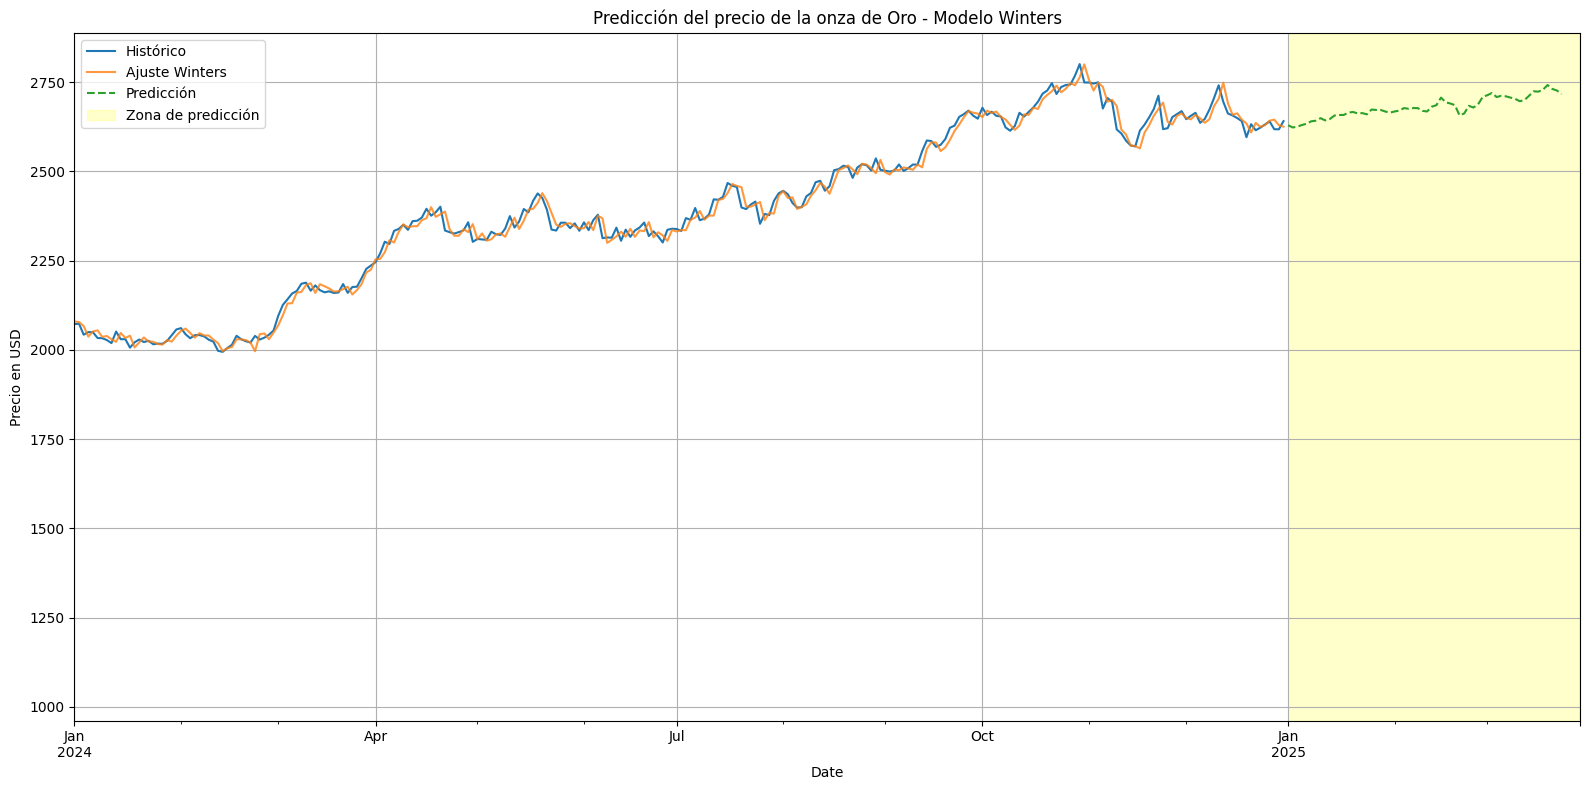

In [223]:
# Gráfica de predicción futura
fig, ax = plt.subplots(figsize=(16, 8))
df_gold['Price'].plot(label='Histórico')
modelo_winters.fittedvalues.plot(label='Ajuste Winters', alpha=0.8)
prediccion.plot(label='Predicción', linestyle='--')
ax.axvspan('2025-01-01', '2025-03-31', color='yellow', alpha=0.2, label='Zona de predicción')
plt.legend()
plt.title('Predicción del precio de la onza de Oro - Modelo Winters')
plt.ylabel('Precio en USD')
plt.grid(True)
# Mostrar solo los años 2024 y 2025
plt.xlim('2024-01-01', '2025-03-31')
plt.tight_layout()
plt.show()

#### Métricas de error

In [224]:
ajuste = modelo_winters.fittedvalues
real = df_gold['Price']

# MSE
mse_winters = mean_squared_error(real, ajuste)
print(f"MSE:  {mse_winters:.2f}")

# MAD
mad_winters = mean_absolute_error(real, ajuste)
print(f"MAD:  {mad_winters:.2f}")

# MAPE
mape_winters = np.mean(np.abs((real - ajuste) / real)) * 100
print(f"MAPE: {mape_winters:.2f}%")

# Desviación estándar
desv_est_winters = mad_winters * 1.25
print(f"Desviación estandar: {desv_est_winters:.2f}")

MSE:  216.26
MAD:  10.48
MAPE: 0.66%
Desviación estandar: 13.10


## 5. Descomposición de la serie (Componente Aleatorio, Tendencia y Estacionalidad)

### Descomposición de la serie

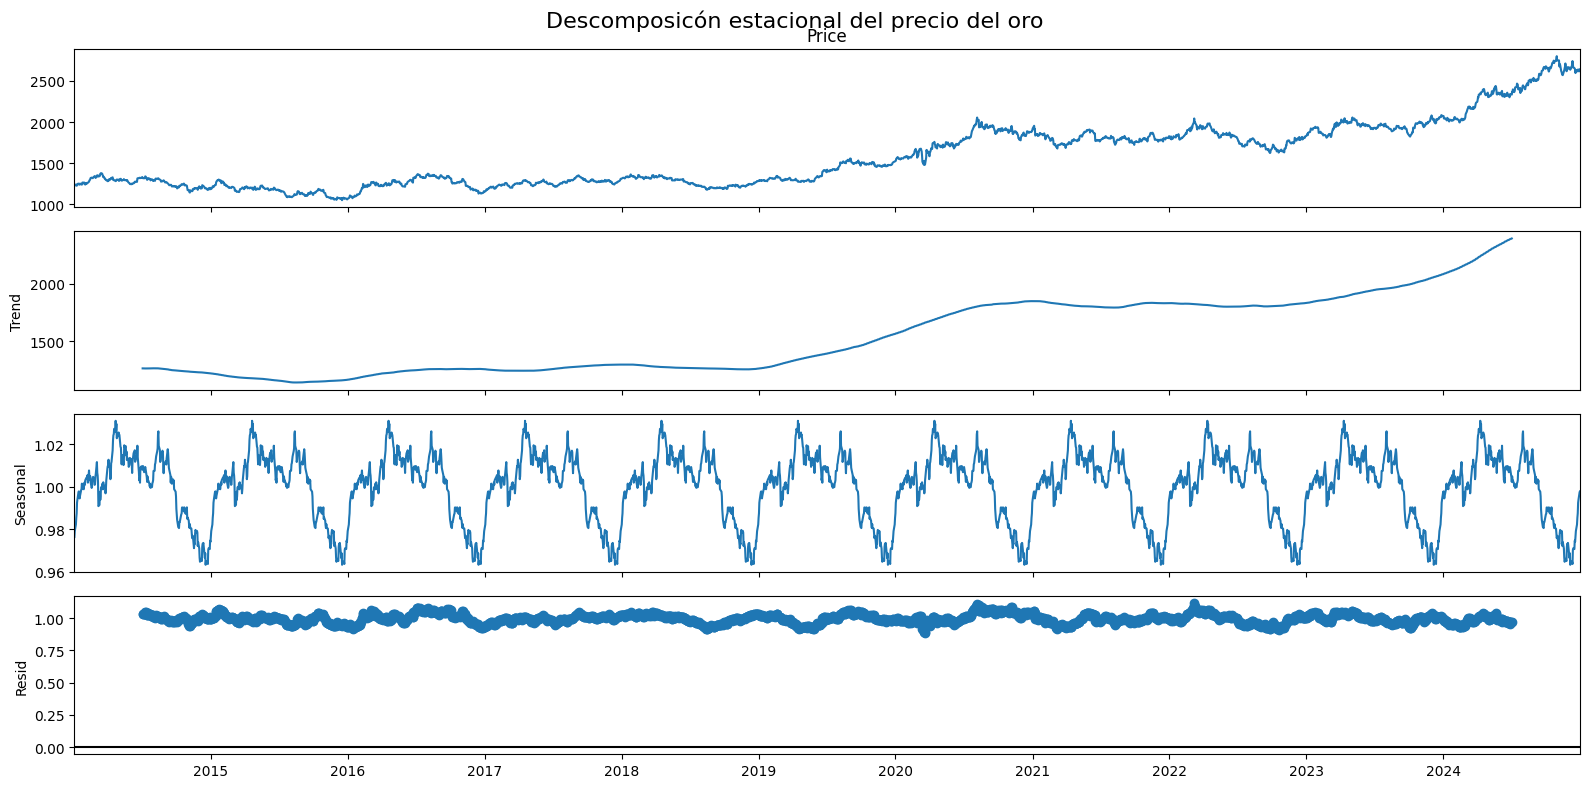

In [225]:
decomposicion = seasonal_decompose(df_gold['Price'], model='multiplicative', period=260)

fig = decomposicion.plot()
fig.set_size_inches(16,8)
plt.suptitle('Descomposicón estacional del precio del oro', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

### Gráficas de serie diferenciada y autocorrelaciones

<Axes: title={'center': 'Serie diferenciada (d=1)'}, xlabel='Date'>

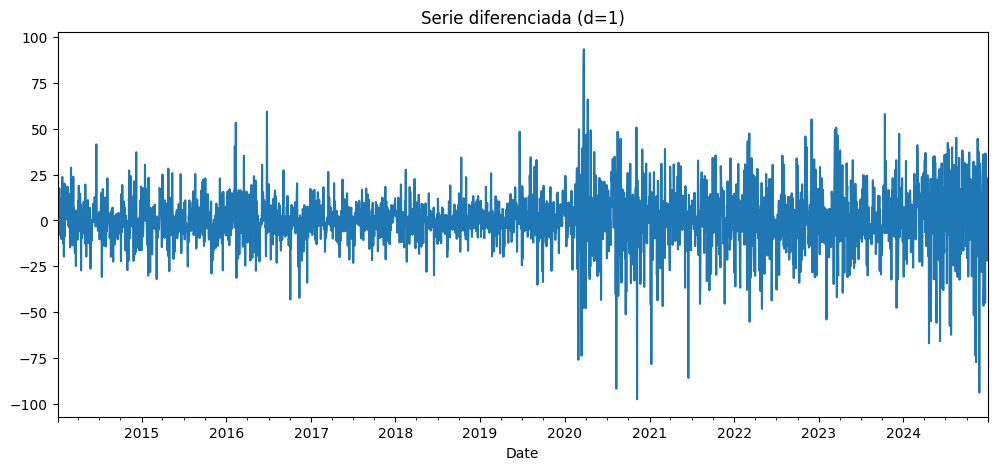

In [226]:
# Diferenciación de primer orden
df_diff = df_gold['Price'].diff().dropna()

# Ver rápida de la serie diferenciada
df_diff.plot(figsize=(12,5), title='Serie diferenciada (d=1)')


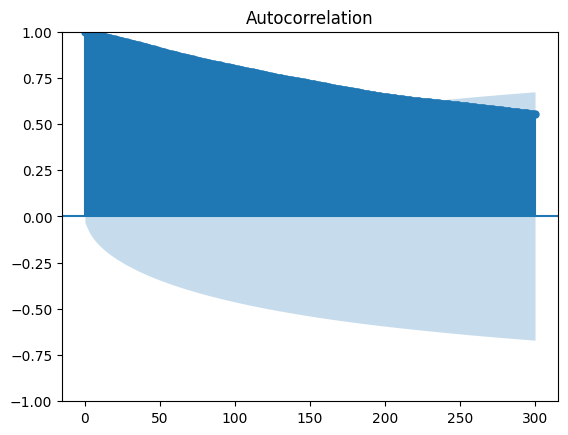

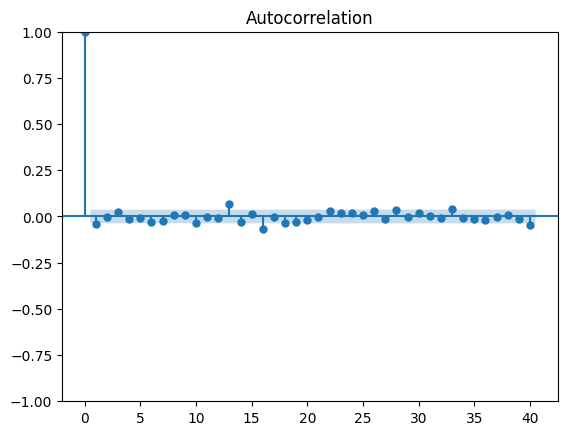

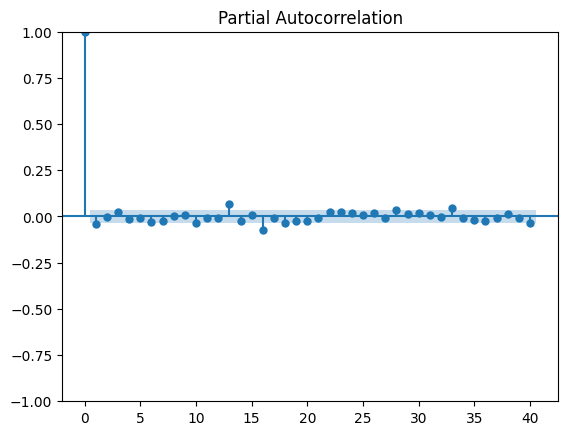

In [227]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_gold['Price'], lags=300)
plt.show()

# Grafícos ACF y PACF para determinar los valores p y q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Grafica ACF para determinar el valor de q
plot_acf(df_diff, lags=40)
plt.show()

# Grafica PACF para determinar el valor de p
plot_pacf(df_diff, lags=40)
plt.show()

* El primer gráfico de autocorrelación muestra una correlación muy alta, en 1.0. Indicando una fuerte dependencia del valor anterior

* No se observan picos visibles, lo que sugiere una estacionalidad leve o disimulada por la tendencia.

* El segundo gráfico de autocorrelación ACF nos da un valor para q de 1

* El gráfico de Partial Autocorrelation PACF nos da un valora para p de 1



## 6. Aplicación del modelo ARIMA

### Modelo

In [228]:
#--- Modelo ARIMA(1,1,1)
modelo_arima = ARIMA(df_gold['Price'], order=(1,1,1)).fit()
modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2869
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11859.944
Date:                Mon, 07 Apr 2025   AIC                          23725.889
Time:                        02:48:35   BIC                          23743.773
Sample:                    01-02-2014   HQIC                         23732.336
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0107      0.336     -0.032      0.975      -0.670       0.649
ma.L1         -0.0306      0.334     -0.091      0.927      -0.686       0.625
sigma2       228.9802      3.232     70.841      0.000     222.645     235.315
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3211.84
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fechas futuras y predicciones

In [229]:
# Pronosticar valores futuros
valores_prediccion_arima = modelo_arima.get_forecast(60).predicted_mean
prediccion_arima = pd.Series(valores_prediccion_arima.values, index=fechas_futuras)
print(prediccion_arima)

2025-01-01    2640.056518
2025-01-02    2640.066589
2025-01-03    2640.066482
2025-01-06    2640.066483
2025-01-07    2640.066483
2025-01-08    2640.066483
2025-01-09    2640.066483
2025-01-10    2640.066483
2025-01-13    2640.066483
2025-01-14    2640.066483
2025-01-15    2640.066483
2025-01-16    2640.066483
2025-01-17    2640.066483
2025-01-20    2640.066483
2025-01-21    2640.066483
2025-01-22    2640.066483
2025-01-23    2640.066483
2025-01-24    2640.066483
2025-01-27    2640.066483
2025-01-28    2640.066483
2025-01-29    2640.066483
2025-01-30    2640.066483
2025-01-31    2640.066483
2025-02-03    2640.066483
2025-02-04    2640.066483
2025-02-05    2640.066483
2025-02-06    2640.066483
2025-02-07    2640.066483
2025-02-10    2640.066483
2025-02-11    2640.066483
2025-02-12    2640.066483
2025-02-13    2640.066483
2025-02-14    2640.066483
2025-02-17    2640.066483
2025-02-18    2640.066483
2025-02-19    2640.066483
2025-02-20    2640.066483
2025-02-21    2640.066483
2025-02-24  

### Evaluación de la calidad del ajuste

#### Gráfica histórico, ajustado y predicción

In [230]:
# Valores ajustados
fitted_arima = modelo_arima.predict(start = 1, end = len(df_gold) - 1, type='leve')

<ipython-input-231-cc45d398b41c>:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(fitted_arima.index, fitted_arima, label="Ajustados ARIMA")
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


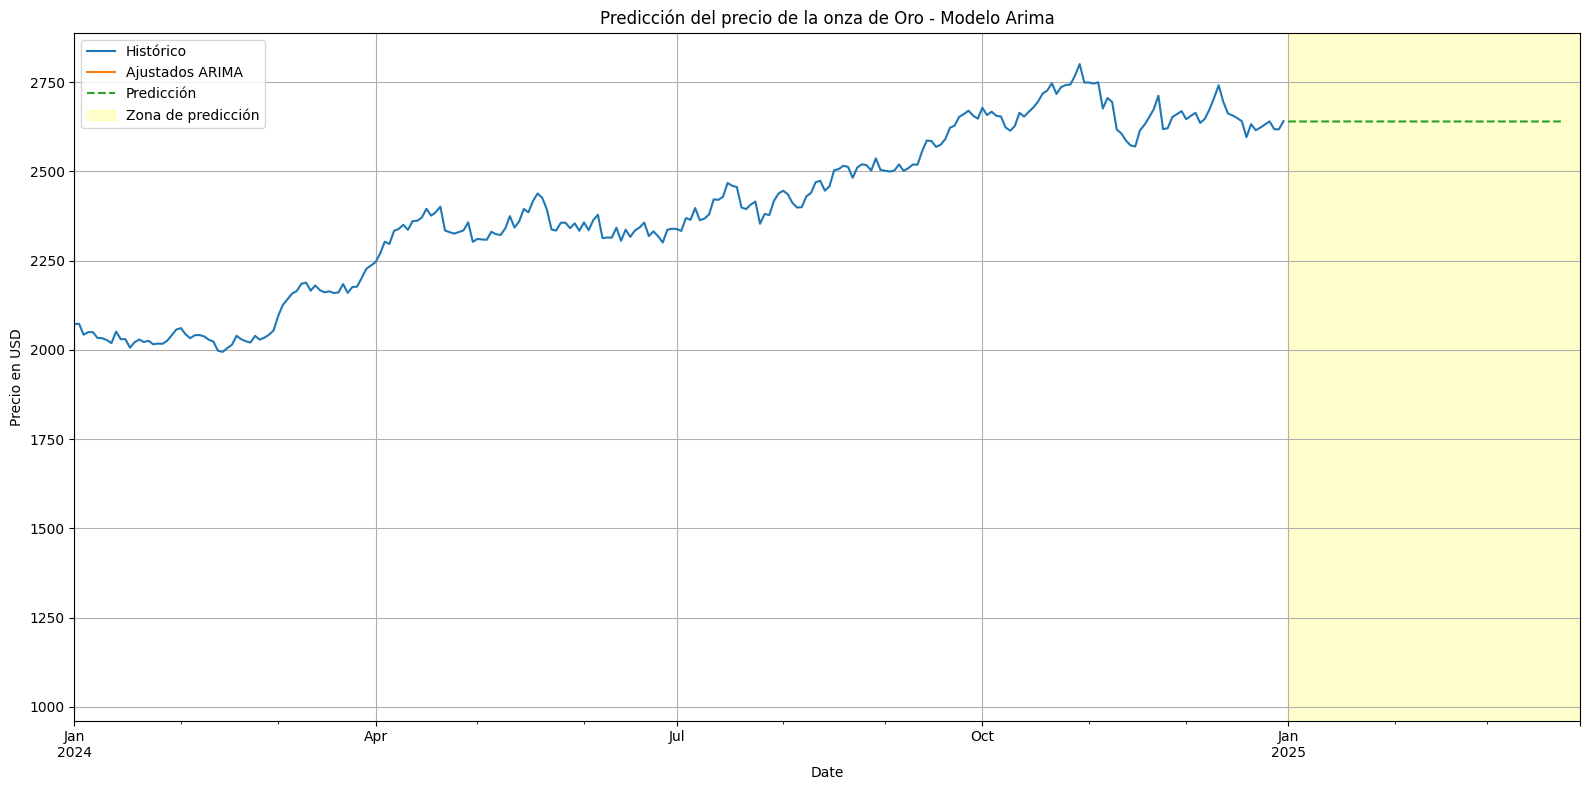

In [231]:
# Gráfica de predicción futura
fig, ax = plt.subplots(figsize=(16, 8))
df_gold['Price'].plot(label='Histórico')
plt.plot(fitted_arima.index, fitted_arima, label="Ajustados ARIMA")
prediccion_arima.plot(label='Predicción', linestyle='--')
ax.axvspan('2025-01-01', '2025-03-31', color='yellow', alpha=0.2, label='Zona de predicción')
plt.legend()
plt.title('Predicción del precio de la onza de Oro - Modelo Arima')
plt.xlabel('Date')
plt.ylabel('Precio en USD')
plt.grid(True)
# Mostrar solo los años 2024 y 2025
plt.xlim('2024-01-01', '2025-03-31')
plt.tight_layout()
plt.show()

#### Métricas de error

In [232]:
ajuste = modelo_arima.fittedvalues
real = df_gold['Price']

# MSE
mse_arima = mean_squared_error(real, ajuste)
print(f"MSE:  {mse_arima:.2f}")

# MAD
mad_arima = mean_absolute_error(real, ajuste)
print(f"MAD:  {mad_arima:.2f}")

# MAPE
mape_arima = np.mean(np.abs((real - ajuste) / real)) * 100
print(f"MAPE: {mape_arima:.2f}%")

# Desviación estándar
desv_est_arima = mad_arima * 1.25
print(f"Desviación estandar: {desv_est_arima:.2f}")

MSE:  751.90
MAD:  10.74
MAPE: 0.68%
Desviación estandar: 13.43


## 7. Aplicación del Modelo SARIMA

### Modelo

In [233]:
#--- Modelo SARIMA (1, 1, 1)x(1, 0, 1, 5)
modelo_sarima = SARIMAX(df_gold['Price'],
                        order=(1,1,1),
                        seasonal_order=(1,0,1,5),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

modelo_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                 2869
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood              -11832.389
Date:                           Mon, 07 Apr 2025   AIC                          23674.778
Time:                                   02:48:36   BIC                          23704.573
Sample:                               01-02-2014   HQIC                         23685.521
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0237      0.324     -0.073      0.942      -0.660       0.612
ma.L1         -0.0191      0.323     -0.059      0.953      -0.652       0.613
ar.S.L5        0.4242      0.473      0.896      0.370      -0.503       1.352
ma.S.L5       -0.4441      0.469     -0.947      0.344      -1.363       0.475
sigma2       228.8427      3.253     70.353      0.000     222.467     235.218
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3175.58
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fechas futuras y predicciones

In [234]:
# Pronosticar valores futuros
resultado_sarima = modelo_sarima.get_forecast(steps=60).predicted_mean
prediccion_sarima = pd.Series(resultado_sarima.values, index=fechas_futuras)
print(prediccion_sarima)




2025-01-01    2639.735559
2025-01-02    2640.199510
2025-01-03    2640.403215
2025-01-06    2640.583347
2025-01-07    2640.024532
2025-01-08    2639.927147
2025-01-09    2640.113546
2025-01-10    2640.200207
2025-01-13    2640.276614
2025-01-14    2640.039560
2025-01-15    2639.998249
2025-01-16    2640.077321
2025-01-17    2640.114083
2025-01-20    2640.146496
2025-01-21    2640.045935
2025-01-22    2640.028410
2025-01-23    2640.061953
2025-01-24    2640.077548
2025-01-27    2640.091298
2025-01-28    2640.048639
2025-01-29    2640.041205
2025-01-30    2640.055435
2025-01-31    2640.062050
2025-02-03    2640.067883
2025-02-04    2640.049787
2025-02-05    2640.046633
2025-02-06    2640.052669
2025-02-07    2640.055476
2025-02-10    2640.057950
2025-02-11    2640.050273
2025-02-12    2640.048936
2025-02-13    2640.051496
2025-02-14    2640.052687
2025-02-17    2640.053736
2025-02-18    2640.050480
2025-02-19    2640.049912
2025-02-20    2640.050999
2025-02-21    2640.051504
2025-02-24  

#### Gráfica histórico, ajustado y predicción

In [235]:
# Valores ajustados
fitted_sarima = modelo_sarima.predict(start = 1, end = len(df_gold) - 1, type='leve')

<ipython-input-236-e8ef6e699b28>:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(fitted_sarima.index, fitted_sarima, label="Ajustados SARIMA")
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


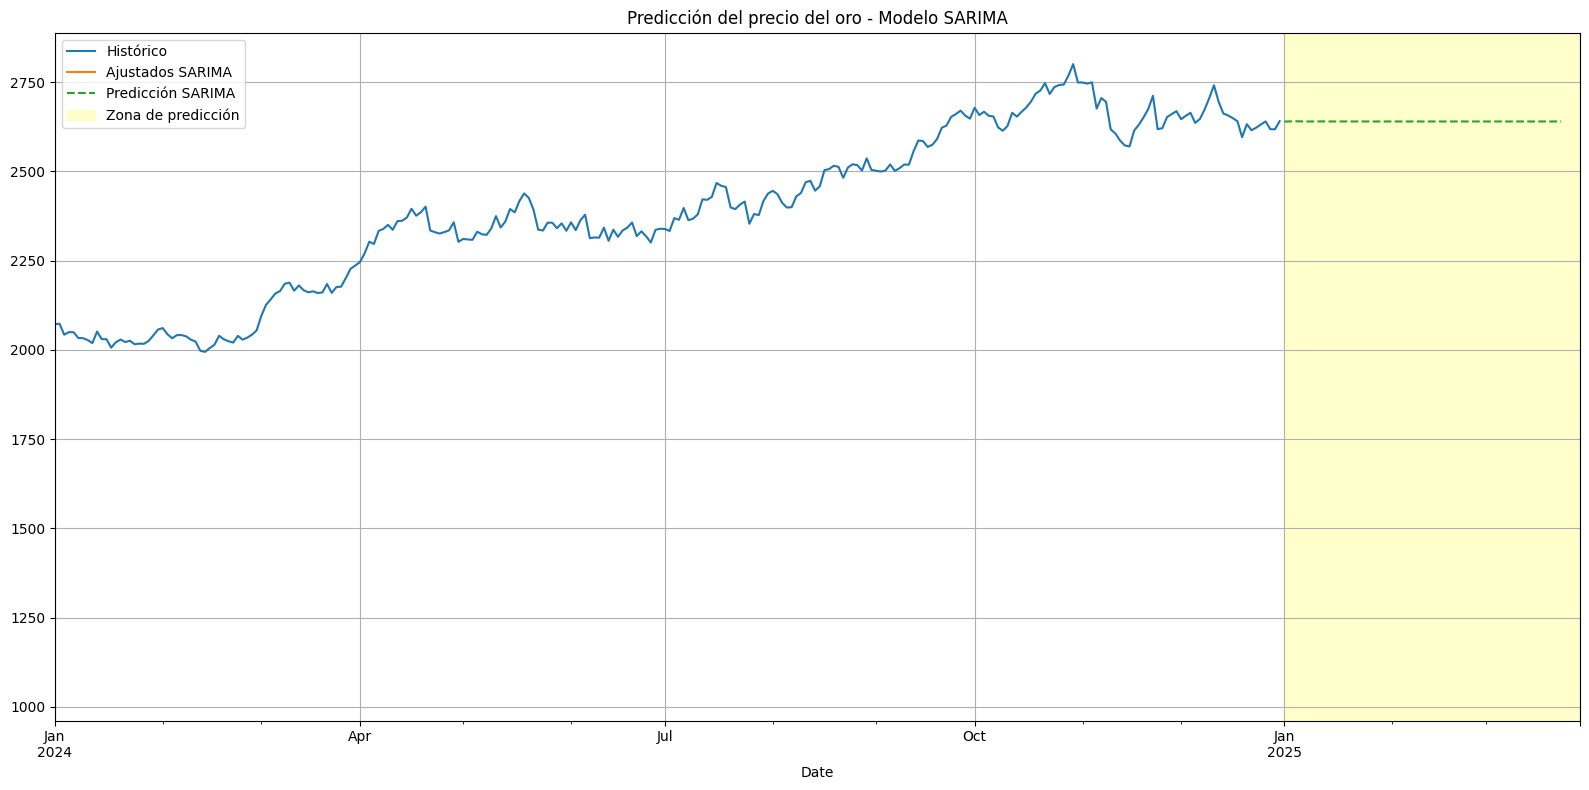

In [236]:
# Gráfica de predicción futura
fig, ax = plt.subplots(figsize=(16, 8))
df_gold['Price'].plot(label='Histórico')
plt.plot(fitted_sarima.index, fitted_sarima, label="Ajustados SARIMA")
prediccion_sarima.plot(label='Predicción SARIMA', linestyle='--')
ax.axvspan('2025-01-01', '2025-03-31', color='yellow', alpha=0.2, label='Zona de predicción')
plt.legend()
plt.title('Predicción del precio del oro - Modelo SARIMA')
plt.grid(True)
# Mostrar solo los años 2024 y 2025
plt.xlim('2024-01-01', '2025-03-31')
plt.tight_layout()
plt.show()

#### Métricas de error

In [237]:
ajuste = modelo_sarima.fittedvalues
real = df_gold['Price']

# MSE
mse_sarima = mean_squared_error(real, ajuste)
print(f"MSE:  {mse_sarima:.2f}")

# MAD
mad_sarima = mean_absolute_error(real, ajuste)
print(f"MAD:  {mad_sarima:.2f}")

# MAPE
mape_sarima = np.mean(np.abs((real - ajuste) / real)) * 100
print(f"MAPE: {mape_sarima:.2f}%")

# Desviación estándar
desv_est_sarima = mad_sarima * 1.25
print(f"Desviación estandar: {desv_est_sarima:.2f}")

MSE:  774.65
MAD:  10.83
MAPE: 0.68%
Desviación estandar: 13.53


## 8. Aplicación del Modelo Prophet

#### Modelo

In [238]:
# Formatear datos
df_prophet = df_gold[['Price']].reset_index()
df_prophet.columns = ['ds', 'y']

In [239]:
# Crear y entrenar el modelo
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2wrx752o/oe9_b6wj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2wrx752o/76ctfjr2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75789', 'data', 'file=/tmp/tmp2wrx752o/oe9_b6wj.json', 'init=/tmp/tmp2wrx752o/76ctfjr2.json', 'output', 'file=/tmp/tmp2wrx752o/prophet_modeleyf7h4hr/prophet_model-20250407024837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:48:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Fechas futuras y predicción

In [240]:
# Fechas futuras y predicción
futuro = modelo_prophet.make_future_dataframe(periods=60, freq='B')
pronostico_prophet = modelo_prophet.predict(futuro)

### Evaluación de la calidad del ajuste

#### Gráfica histórico, ajustado y predicción

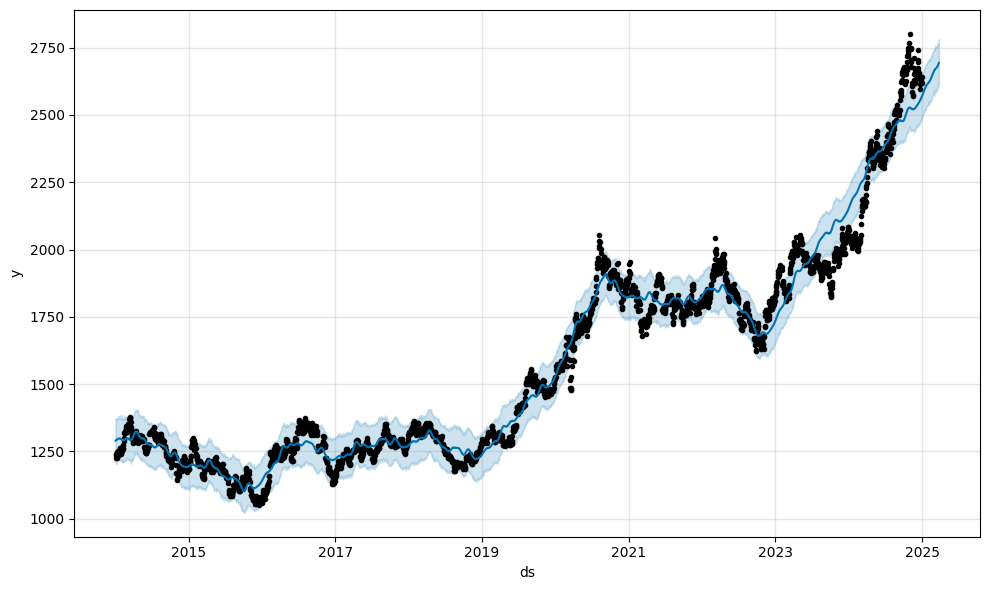

In [241]:
fig1 = modelo_prophet.plot(pronostico_prophet)

#### Métricas de error

In [242]:
# Unir los valores reales con los valores ajustados
df_eval = df_prophet.set_index('ds').join(pronostico_prophet.set_index('ds')[['yhat']], how='inner')

# MSE
mse_prophet = mean_squared_error(df_eval['y'], df_eval['yhat'])
print(f"MSE:  {mse_prophet:.2f}")
# MAD
mad_prophet = mean_absolute_error(df_eval['y'], df_eval['yhat'])
print(f"MAD:  {mad_prophet:.2f}")
# MAPE
mape_prophet = np.mean(np.abs((df_eval['y'] - df_eval['yhat']) / df_eval['y'])) * 100
print(f"MAPE: {mape_prophet:.2f}%")
# Desviación estándar
desv_est_prophet = mad_prophet * 1.25
print(f"Desviación estandar: {desv_est_prophet:.2f}")

MSE:  3855.11
MAD:  45.46
MAPE: 2.78%
Desviación estandar: 56.82


# 9. Resumen de métricas de errores

In [243]:
metodos = ['Winters', 'ARIMA', 'SARIMA', 'Prophet']
MSE = [mse_winters, mse_arima, mse_sarima, mse_prophet]
MAD = [mad_winters, mad_arima, mad_sarima, mad_prophet]
MAPE = [mape_winters, mape_arima, mad_sarima, mad_prophet]
Desv_Estandar = [desv_est_winters, desv_est_arima, desv_est_sarima, desv_est_prophet]

tabla_modelos = pd.DataFrame({
    'Método de pronóstico': metodos,
    'MSE': MSE,
    'MAD': MAD,
    'MAPE %': MAPE,
    'Desv. Estándar': Desv_Estandar
}
)

print(tabla_modelos)

  Método de pronóstico          MSE        MAD     MAPE %  Desv. Estándar
0              Winters   216.257818  10.477165   0.660183       13.096457
1                ARIMA   751.895031  10.740799   0.676150       13.425999
2               SARIMA   774.651662  10.826123  10.826123       13.532654
3              Prophet  3855.108535  45.455024  45.455024       56.818780
